# Robot Weightlifting
The Robot Weightlifting World Championship’s final round is about to begin! Three robots, seeded 1, 2, and 3, remain in contention. They take turns from the 3rd seed to the 1st seed publicly declaring exactly how much weight (any nonnegative real number) they will attempt to lift, and no robot can choose exactly the same amount as a previous robot. Once the three weights have been announced, the robots attempt their lifts, and the robot that successfully lifts the most weight is the winner. If all robots fail, they just repeat the same lift amounts until at least one succeeds.

Assume the following:

1) all the robots have the same probability p(w) of successfully lifting a given weight w;

2) p(w) is exactly known by all competitors, continuous, strictly decreasing as the w increases, p(0) = 1, and p(w) -> 0 as w -> infinity; and

3) all competitors want to maximize their chance of winning the RWWC.

If w is the amount of weight the 3rd seed should request, find p(w). Give your answer to an accuracy of six decimal places.

In [2]:
import numpy as np
import itertools as it
import math
from decimal import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

EPSILON = Decimal("0.00000000000000001")

In [3]:
sns.set_theme()

# $w$ vs $p(w)$
To avoid thinking about a specific implementation of $p(w)$, we simply do not think in terms of weights.
We consider different probabilities, and can deduce whether seed 1, 2, or 3 wins by taking the seed with the lowest corresponding probability.

($p(w)$ is continuous and strictly decreasing, and therefore bijective.)

# Phase 1: wide search across whole space
We will brute force combinations of $p_1,p_2,p_3$. We compute the probability that the 3-seed wins the tournament. We will take the arrangement that results in the highest probability of a 3-seed win for phase 2: gradient descent. By doing a random search at the start across the whole search space, we make sure we do not end up in a local minimum.

In [4]:
# deliberately chose the verbose way to keep these functions relatively easy to reason about.
one = Decimal('1')
def compute_probability_3_win(p1, p2, p3):
    r = (one-p1)*(one-p2)*(one-p3)
    
    win_prob = (one-p1)*(one-p2)*p3
    if p3 < p2:
        # 3 heavier than 2
        win_prob += (one-p1)*p2*p3
    if p3 < p1:
        # 3 heavier than 1
        win_prob += p1*(one-p2)*p3
    if p3 < p2 and p3 < p1:
        # 3 heaviest
        win_prob += p1*p2*p3
    
    return win_prob/(one-r)

def compute_probability_2_win(p1, p2, p3):
    r = (one-p1)*(one-p2)*(one-p3)
    
    win_prob = (one-p1)*p2*(one-p3)
    if p2 < p3:
        # 2 heavier than 3
        win_prob += (one-p1)*p2*p3
    if p2 < p1:
        # 2 heavier than 1
        win_prob += p1*p2*(one-p3)
    if p2 < p3 and p2 < p1:
        # 2 heaviest
        win_prob += p1*p2*p3
    
    return win_prob/(one-r)

def compute_probability_1_win(p1, p2, p3):
    r = (one-p1)*(one-p2)*(one-p3)
    
    win_prob = p1*(one-p2)*(one-p3)
    if p1 < p2:
        # 1 heavier than 2
        win_prob += p1*p2*(one-p3)
    if p1 < p3:
        # 1 heavier than 3
        win_prob += p1*(one-p2)*p3
    if p1 < p2 and p1 < p3:
        # 1 heaviest
        win_prob += p1*p2*p3
    
    return win_prob/(one-r)

In [53]:
num_ps = 400
p1s = list(map(Decimal, np.linspace(0, 1, num=num_ps)))
p2s = list(map(Decimal, np.linspace(0, 1, num=num_ps)))
p3s = list(map(Decimal, np.linspace(0.1, 0.5, num=num_ps)))

y = np.zeros(shape=(num_ps, 3), dtype=np.double) # columns: ["probability_3_wins", "corresp_p1", "corresp_p2"]

In [54]:
maximum_1_2_3 = (Decimal(0), (Decimal(-1), Decimal(-1), Decimal(-1)))
for (i, p3) in enumerate(p3s):
    maximum_1_2 = (Decimal(0), (Decimal(-1), Decimal(-1)))
    for p2 in p2s:
        if (p2 == p3): continue
        maximum_1 = (Decimal(0), Decimal(-1))
        for p1 in p1s:
            if (p1 == p2): continue
            if (p1 == p3): continue
            prob = compute_probability_1_win(p1, p2, p3)
            if prob > maximum_1[0]:
                maximum_1 = (prob, p1)
        prob = compute_probability_2_win(maximum_1[1], p2, p3)
        if prob > maximum_1_2[0]:
            maximum_1_2 = (prob, (maximum_1[1], p2))
    prob = compute_probability_3_win(maximum_1_2[1][0], maximum_1_2[1][1], p3)
    y[i] = [prob, maximum_1_2[1][0], maximum_1_2[1][1]]
    if prob > maximum_1_2_3[0]:
        maximum_1_2_3 = (prob, (maximum_1_2[1][0], maximum_1_2[1][1], p3))

print(f"""
Maximum probability of 3 win: {maximum_1_2_3[0]}
p1 = {maximum_1_2_3[1][0]}
p2 = {maximum_1_2_3[1][1]}
p3 = {maximum_1_2_3[1][2]}""")


Maximum probability of 3 win: 0.2880626071075443168687853231
p1 = 0.288220551378446099288765935853007249534130096435546875
p2 = 0.44110275689223055195498091052286326885223388671875
p3 = 0.29047619047619044341246308249537833034992218017578125


In [55]:
# manual sanity check, p(1 wins v 2 wins v 3 wins) = 1
print(compute_probability_1_win(Decimal(0.2870493991989319), Decimal(0.4379172229639519), Decimal(0.2883845126835781)))

0.4015636373756209943693535801


# Graph
Let's plot $p_3$ vs the probability of 3 winning, and see if we can spot a maximum.

In [56]:
df = pd.DataFrame(index=map(float, p3s), columns=["probability_3_wins", "corresp_p1", "corresp_p2"], data=y)
df

,probability_3_wins,corresp_p1,corresp_p2
0.100000,0.100000,1.000000,0.406015
0.101003,0.101003,1.000000,0.406015
0.102005,0.102005,1.000000,0.406015
0.103008,0.103008,1.000000,0.406015
0.104010,0.104010,1.000000,0.406015
...,...,...,...
0.495990,0.209071,0.493734,0.313283
0.496992,0.207231,0.496241,0.315789
0.497995,0.207562,0.496241,0.315789
0.498997,0.206644,0.498747,0.315789


Text(0.5, 1.05, 'P(3 wins)')

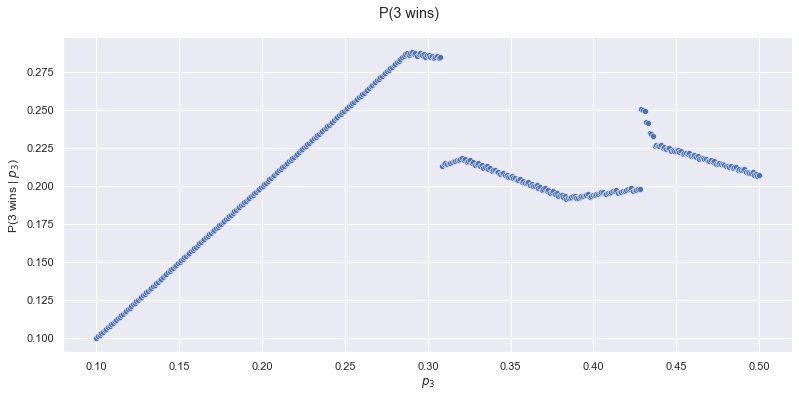

In [57]:
g = sns.relplot(data=df, x=df.index, y="probability_3_wins", aspect = 22/10, height=5)
g.set_axis_labels("$p_3$", "P(3 wins | $p_3$)")
g.fig.suptitle("P(3 wins)", y=1.05)

In [59]:
# select data from just the peak around p3 = 0.28
peak_data = df[0.27 < df['probability_3_wins']].reset_index()
peak_data["p1 = 1.0"] = (peak_data["corresp_p1"] > 0.95)
peak_data["probability_2_wins"] = peak_data.apply(lambda x: float(compute_probability_2_win(Decimal(x["corresp_p1"]), Decimal(x["corresp_p2"]), Decimal(x["index"]))), axis=1)
peak_data

,index,probability_3_wins,corresp_p1,corresp_p2,p1 = 1.0,probability_2_wins
0,0.270426,0.270426,1.000000,0.433584,True,0.316332
1,0.271429,0.271429,1.000000,0.433584,True,0.315897
2,0.272431,0.272431,1.000000,0.433584,True,0.315462
3,0.273434,0.273434,1.000000,0.433584,True,0.315028
4,0.274436,0.274436,1.000000,0.433584,True,0.314593
5,0.275439,0.275439,1.000000,0.433584,True,0.314158
6,0.276441,0.276441,1.000000,0.436090,True,0.315537
7,0.277444,0.277444,1.000000,0.436090,True,0.315100
8,0.278446,0.278446,1.000000,0.436090,True,0.314663
9,0.279449,0.279449,1.000000,0.436090,True,0.314225


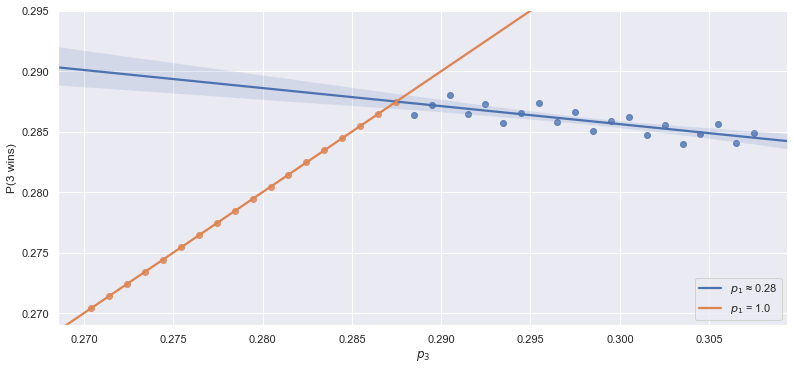

In [61]:
g = sns.lmplot(
    data=peak_data, 
    x="index", 
    y="probability_3_wins", 
    hue="p1 = 1.0",
    truncate = False,
    aspect = 22/10,
    height = 5,
    legend = False
)
g.set(ylim=(0.269, 0.295))
g.set_axis_labels("$p_3$", "P(3 wins)")
plt.legend(loc='lower right', labels=['$p_1$ ≈ 0.28', '$p_1$ = 1.0'])
plt.show(g)

# Private notes
WE NEED TO FIND THE MINIMUM p3 S.T. P1 != 1, but P1 = P3 - epsilon

Solve w/ calculus?

# Phase 1.5

We see from the graph that we need to find the point around 2.87-2.88 where the switch is happening. We can see in the answers that this corresponds to a totally different 

In [17]:
one = Decimal("1")
# def check_p3(p3):
#     # checks whether p3 has become too low
#     # the switch is somewhere around 0.287-0.288
    
#     # Optimal p2, check algebra
#     p2 = (2*p3 - one)/(p3 - one)
    
#     r = (one-p3)*(one-p2)*(one-p3)
#     win_prob = (one-p3)*(one-p2)*p3 + (one-p3)*p2*p3
#     return p2, win_prob/(one-r)

def check_p3(p3):
    # checks whether p3 has become too low
    # the switch is somewhere around 0.287-0.288
    
    # Optimal p2, check algebra
    p2 = (p3**2) / (p3**2 - 1)
    
    r = (one-p3)*(one-p2)*(one-p3)
    win_prob = (one-p3)*(one-p2)*p3 + (one-p3)*p2*p3
    return p2, win_prob/(one-r)

for p3 in np.linspace(0.275, 0.29, num=10):
    p2, prob = check_p3(Decimal(p3))
    print(f"{p3:.3f}\t{p2:.3f}\t{prob:.3f}")

0.275	-0.082	0.462
0.277	-0.083	0.462
0.278	-0.084	0.461
0.280	-0.085	0.461
0.282	-0.086	0.460
0.283	-0.087	0.460
0.285	-0.088	0.459
0.287	-0.090	0.459
0.288	-0.091	0.458
0.290	-0.092	0.458


# Peel the onion
p3 is given, compute the optimal p2 to 6 decimal places significant to maximize P(2 wins)


In [63]:
p3 = Decimal(0.2883845126835781)
num_ps = 850
p1s = list(map(Decimal, np.linspace(0, 1, num=num_ps)))
p2s = list(map(Decimal, np.linspace(0, 1, num=num_ps)))

z = np.zeros(shape=(num_ps, 2), dtype=np.double) # columns: ["probability_2_wins", "corresp_p1"]

maximum_1_2 = (Decimal(0), (Decimal(-1), Decimal(-1)))
for (i, p2) in enumerate(p2s):
    if (p2 == p3): continue
    maximum_1 = (Decimal(0), Decimal(-1))
    for p1 in p1s:
        if (p1 == p2): continue
        if (p1 == p3): continue
        prob = compute_probability_1_win(p1, p2, p3)
        if prob > maximum_1[0]:
            maximum_1 = (prob, p1)
    prob = compute_probability_2_win(maximum_1[1], p2, p3)
    if prob > maximum_1_2[0]:
        maximum_1_2 = (prob, (maximum_1[1], p2))
    z[i] = [prob, maximum_1[1]]

print(f"""
Maximum probability of 2 win: {maximum_1_2[0]}
p1 = {maximum_1_2[1][0]}
p2 = {maximum_1_2_3[1][1]}""")


Maximum probability of 2 win: 0.3107177443549380472647106471
p1 = 0.287396937573616007011167994278366677463054656982421875
p2 = 0.44110275689223055195498091052286326885223388671875


In [64]:
df2 = pd.DataFrame(index=map(float, p2s), columns=["probability_2_wins", "corresp_p1"], data=z)
df2

,probability_2_wins,corresp_p1
0.000000,0.000000,1.000000
0.001178,0.001178,1.000000
0.002356,0.002356,1.000000
0.003534,0.003534,1.000000
0.004711,0.004711,1.000000
...,...,...
0.995289,0.004171,0.994111
0.996466,0.003341,0.995289
0.997644,0.002509,0.996466
0.998822,0.001674,0.997644


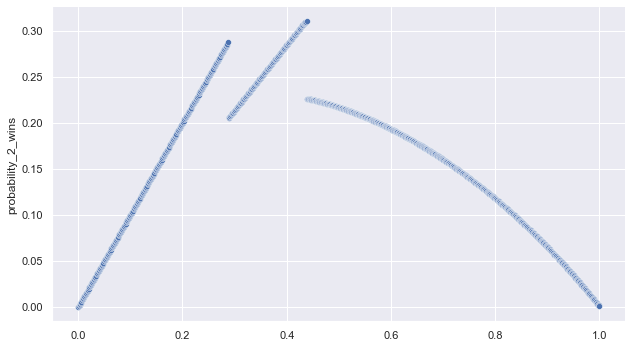

In [65]:
sns.relplot(data=df2, x=df2.index, y="probability_2_wins", aspect = 1.75)

In [66]:
peak_data2 = df2.reset_index()
peak_data2 = peak_data2[0.4 < peak_data2["index"]]
peak_data2 = peak_data2[peak_data2["index"] < 0.5]
def g(val):
    if val > 0.9: 
        return 0
    elif ((0.28 < val) and (val < 0.29)): 
        return 1
    else: 
        return 2
peak_data2["p1"] = peak_data2.apply(lambda x: g(x["corresp_p1"]), axis=1)
print(peak_data2.to_string())

        index  probability_2_wins  corresp_p1  p1
340  0.400471            0.284981    1.000000   0
341  0.401649            0.285820    1.000000   0
342  0.402827            0.286658    1.000000   0
343  0.404005            0.287496    1.000000   0
344  0.405183            0.288334    1.000000   0
345  0.406360            0.289172    1.000000   0
346  0.407538            0.290011    1.000000   0
347  0.408716            0.290849    1.000000   0
348  0.409894            0.291687    1.000000   0
349  0.411072            0.292525    1.000000   0
350  0.412250            0.293363    1.000000   0
351  0.413428            0.294201    1.000000   0
352  0.414605            0.295040    1.000000   0
353  0.415783            0.295878    1.000000   0
354  0.416961            0.296716    1.000000   0
355  0.418139            0.297554    1.000000   0
356  0.419317            0.298392    1.000000   0
357  0.420495            0.299231    1.000000   0
358  0.421673            0.300069    1.000000   0


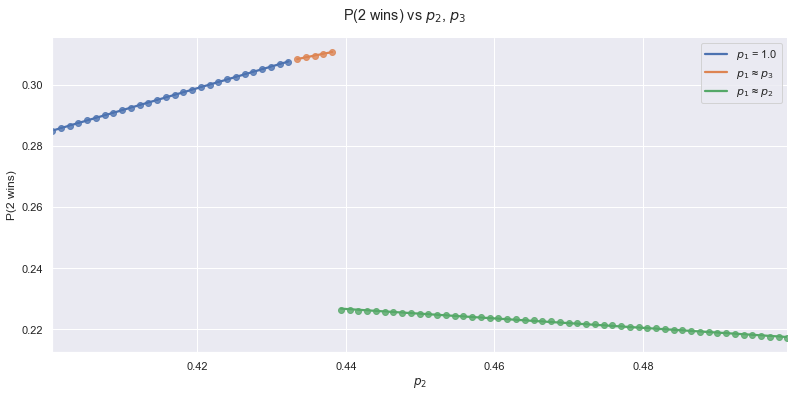

In [74]:
g = sns.lmplot(
    data=peak_data2, 
    x="index", 
    y="probability_2_wins", 
    hue="p1",
    aspect = 22/10,
    height=5,
    legend = False
)
g.set_axis_labels("$p_2$", "P(2 wins)")
g.fig.suptitle("P(2 wins) vs $p_2$, $p_3 \approx 0.288$", y=1.05)
plt.legend(loc='upper right', labels=['$p_1$ = 1.0', '$p_1$ ≈ $p_3$', '$p_1$ ≈ $p_2$', ])
plt.show(g)

The switch from 1.0 to p3 is somewhere around p2 = 0.433451

Now we want to find an indicator function for p1 = p3

In [70]:
p2 = Decimal(0.433451)
num_ps = 850
p1s = list(map(Decimal, np.linspace(0, 1, num=num_ps)))

w = np.zeros(shape=(num_ps), dtype=np.double) # columns: ["probability_1_wins"]


maximum_1 = (Decimal(0), Decimal(-1))
for i, p1 in enumerate(p1s):
    if (p1 == p2): continue
    if (p1 == p3): continue
    prob = compute_probability_1_win(p1, p2, p3)
    w[i] = prob

    if prob > maximum_1[0]:
        maximum_1 = (prob, p1)

print(f"""
Maximum probability of 1 win: {maximum_1[0]}
p1 = {maximum_1_2[1]}""")


Maximum probability of 1 win: 0.4032490308874268978537316081
p1 = (Decimal('0.287396937573616007011167994278366677463054656982421875'), Decimal('0.438162544169611256617002936764038167893886566162109375'))


In [71]:
df3 = pd.DataFrame(index=map(float, p2s), columns=["probability_1_wins"], data=w)
df3

,probability_1_wins
0.000000,0.000000
0.001178,0.001972
0.002356,0.003941
0.003534,0.005906
0.004711,0.007869
...,...
0.995289,0.402029
0.996466,0.402314
0.997644,0.402598
0.998822,0.402881


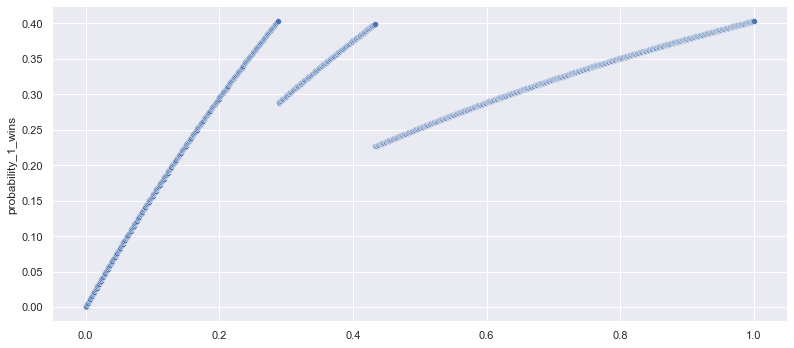

In [72]:
sns.relplot(data=df3, x=df3.index, y="probability_1_wins", aspect = 22/10, height=5)

# Values of $p_1$
We see there are 3 possible optimal values of p1: p3, p2 and 1.0.

Notice the probability of 1 winning is (nearly) equal among all 3 options:

if one option were significantly better, then that would mean that player 2, 3 had better options to restrict player 1 such that they would have a higher probability of winning. 

We simply enumerate all 3 and check which one is best.

In [26]:
def indicate_p1(p2, p3):
    # case 0: p1 = p3
    # 1 is heaviest
    win_prob_case_0 = (
        p3 * (1-p2) * (1-p3) 
      + p3 * p2     * (1-p3) 
      + p3 * (1-p2) * p3
      + p3 * p2     * p3) / (1 - (1-p3) * (1-p2) * (1-p3))
    
    # case 1: p1 = p2
    # 1 heavier than 2, but lighter than 3
    win_prob_case_1 = (
        p2 * (1-p2) * (1-p3) 
      + p2 * p2     * (1-p3)) / (1 - (1-p2) * (1-p2) * (1-p3))
    
    # case 2: p1 = 1.0
    # 1 lightest
    win_prob_case_2 = (1-p2) * (1-p3)
    
    mx = win_prob_case_0.max(win_prob_case_1).max(win_prob_case_2)
    if mx == win_prob_case_0: 
        return 0
    if mx == win_prob_case_1: 
        return 1
    if mx == win_prob_case_2: 
        return 2

In [73]:
peak_data2["p1category_indicator_function"] = peak_data2["index"].map(lambda p2: indicate_p1(Decimal(p2), p3))
g = sns.lmplot(
    data=peak_data2, 
    x="index", 
    y="probability_2_wins", 
    hue="p1category_indicator_function",
    aspect = 22/10,
    height=5,
    legend = False
)
g.set_axis_labels("$p_2$", "P(2 wins)")
plt.legend(loc='upper right', labels=['$p_1$ ≈ $p_3$', '$p_1$ ≈ $p_2$', '$p_1$ = 1.0', ])
plt.show(g)

NameError: name 'indicate_p1' is not defined

# Binary search
We found the indicator!

Given a p3, we can binary search the optimal value for p2 such that we maximize P(2 wins)

In [28]:
p3 = Decimal(0.288)
ITERATIONS = 100
def find_opt_p2(p3):
    lo = Decimal(0)
    hi = Decimal(1)
    for _ in range(ITERATIONS):
        mid = (lo + hi) / 2
#         print(mid)
        ind = indicate_p1(mid, p3)
        if ind == 2 or ind == 0: # p1 = 1.0 or p1 = p3
            lo = mid
        else: # p1 = p2
            hi = mid
            
    return (lo + hi) / 2

find_opt_p2(p3)

Decimal('0.4385190562889777850151014954')

With our optimal p2, we will repeat finding the graph from above.

In [29]:
num_ps = 1000
p3s = list(map(Decimal, np.linspace(0, 1, num=num_ps)))

In [30]:
k = np.zeros(shape=(num_ps, 3), dtype=np.double) # columns: ["probability_3_wins", "corresp_p1", "corresp_p2"]

In [31]:
maximum_1_2_3 = (Decimal(0), (Decimal(-1), Decimal(-1), Decimal(-1)))
for (i, p3) in enumerate(p3s):
    maximum_1_2 = (Decimal(0), (Decimal(-1), Decimal(-1)))
    p2 = find_opt_p2(p3)
    p1 = p3 - EPSILON
    prob = compute_probability_3_win(p1, p2, p3)
    k[i] = [prob, p1, p2]
    if prob > maximum_1_2_3[0]:
        maximum_1_2_3 = (prob, (p1, p2, p3))

print(f"""
Maximum probability of 3 win: {maximum_1_2_3[0]}
p1 = {maximum_1_2_3[1][0]}
p2 = {maximum_1_2_3[1][1]}
p3 = {maximum_1_2_3[1][2]}""")


Maximum probability of 3 win: 0.2867609312239127044099124574
p1 = 0.2872872872872872973468724670
p2 = 0.4370040575181630422907068752
p3 = 0.287287287287287307346872466951026581227779388427734375


    Maximum probability of 3 win: 0.2868329055398742404346004720
    p1 = 0.2868368368358368059861950314
    p2 = 0.4360477681564420399608583872
    p3 = 0.286836836836836805986195031437091529369354248046875

In [32]:
p3 = Decimal("0.286836836836836805986195031437091529369354248046875")
p2 = find_opt_p2(p3)
p1 = p3 - EPSILON
# p1 = p2 - EPSILON
# p1 = Decimal(1)
print(compute_probability_1_win(p1, p2, p3))
print(compute_probability_2_win(p1, p2, p3))
print(compute_probability_3_win(p1, p2, p3))

0.4021981509351827544240926441
0.3109689435255069554928939121
0.2868329055393102900830134440


In [33]:
df4 = pd.DataFrame(index=map(float, p3s), columns=["probability_3_wins", "corresp_p1", "corresp_p2"], data=k).reset_index()
df4

,index,probability_3_wins,corresp_p1,corresp_p2
0,0.000000,0.000000,-1.000000e-17,0.381966
1,0.001001,0.002608,1.001001e-03,0.382242
2,0.002002,0.005190,2.002002e-03,0.382517
3,0.003003,0.007747,3.003003e-03,0.382791
4,0.004004,0.010278,4.004004e-03,0.383064
...,...,...,...,...
995,0.995996,0.003988,9.959960e-01,1.000000
996,0.996997,0.002994,9.969970e-01,1.000000
997,0.997998,0.001998,9.979980e-01,1.000000
998,0.998999,0.001000,9.989990e-01,1.000000


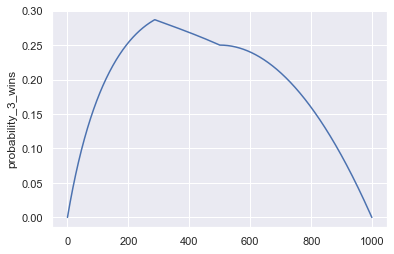

In [34]:
g = sns.lineplot(data=df4, x=df4.index, y="probability_3_wins")


# Peak finding
We have this curve we can calculate arbitrary points on. Now we're going to find the peak.
Again, by binary search.

In [35]:
def is_right(p3):
    p3plus = p3 + EPSILON
    obj = compute_probability_3_win(p3 - EPSILON, find_opt_p2(p3), p3)
    objplus = compute_probability_3_win(p3, find_opt_p2(p3plus), p3plus)
    return objplus < obj

In [36]:
df4["is_right"] = df4.apply(lambda row: is_right(Decimal(row["index"])), axis=1)
df4

,index,probability_3_wins,corresp_p1,corresp_p2,is_right
0,0.000000,0.000000,-1.000000e-17,0.381966,False
1,0.001001,0.002608,1.001001e-03,0.382242,False
2,0.002002,0.005190,2.002002e-03,0.382517,False
3,0.003003,0.007747,3.003003e-03,0.382791,False
4,0.004004,0.010278,4.004004e-03,0.383064,False
...,...,...,...,...,...
995,0.995996,0.003988,9.959960e-01,1.000000,True
996,0.996997,0.002994,9.969970e-01,1.000000,True
997,0.997998,0.001998,9.979980e-01,1.000000,True
998,0.998999,0.001000,9.989990e-01,1.000000,True


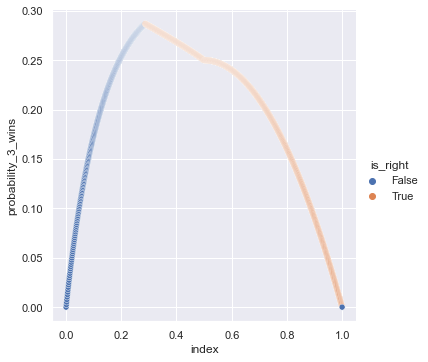

In [37]:
g = sns.relplot(data=df4, x="index", y="probability_3_wins", hue="is_right")

Works! Now a binary search

In [38]:
def find_opt_p3():
    lo = Decimal(0.28)
    hi = Decimal(0.29)
    for _ in range(ITERATIONS):
        mid = (lo + hi) / 2
        print(mid)
        ind = is_right(mid)
        if ind: 
            hi = mid
        else:
            lo = mid
            
    return (lo + hi) / 2

find_opt_p3()

0.2850000000000000033306690739
0.2874999999999999916733273153
0.2862499999999999975019981946
0.2868749999999999945876627550
0.2865624999999999960448304748
0.2867187499999999953162466149
0.2867968749999999949519546850
0.2868359374999999947698087200
0.2868164062499999948608817025
0.2868261718749999948153452112
0.2868310546874999947925769656
0.2868334960937499947811928428
0.2868322753906249947868849042
0.2868328857421874947840388735
0.2868331909179687447826158582
0.2868333435058593697819043505
0.2868334197998046822815485966
0.2868334579467773385313707197
0.2868334388732910104064596582
0.2868334484100341744689151890
0.2868334436416625924376874236
0.2868334460258483834533013063
0.2868334472179412789611082476
0.2868334466218948312072047770
0.2868334469199180550841565123
0.2868334470689296670226323800
0.2868334471434354729918703138
0.2868334471061825700072513469
0.2868334471248090214995608304
0.2868334471341222472457155721
0.2868334471387788601187929430
0.2868334471364505536822542576
0.286833

Decimal('0.2868334471347627725855086390')

# Final answer
$p_3$ = 0.2868334471347588435392189968

In [39]:
p3 = Decimal("0.29")
p2 = find_opt_p2(p3)
p1 = Decimal("0.28999")
# p1 = p2 - EPSILON
# p1 = Decimal(1)
print(compute_probability_1_win(p1, p2, p3))
print(compute_probability_2_win(p1, p2, p3))
print(compute_probability_3_win(p1, p2, p3))

0.4032662891650815701283613635
0.3104007393140767662764009490
0.2863329715208416635952376875


(0.28, 0.29)

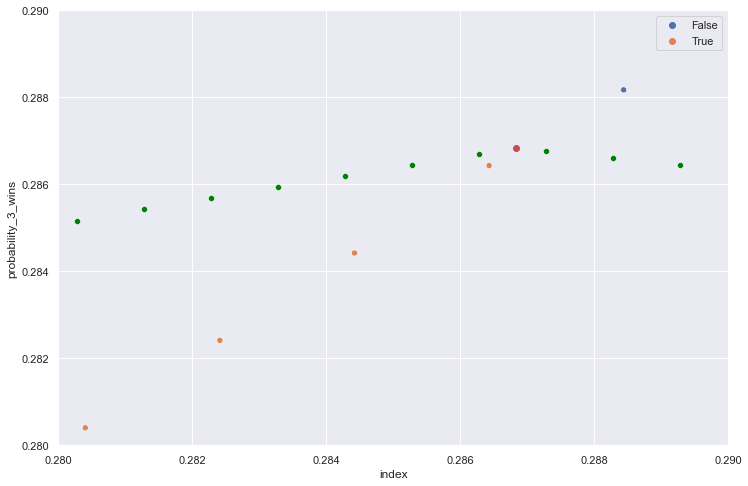

In [40]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
sns.scatterplot(data=df, x=df.index, y="probability_3_wins", hue=(df["corresp_p1"] > 0.9), ax = ax)
sns.scatterplot(data=df4, x="index", y="probability_3_wins", color="green", ax = ax)
plt.plot(Decimal("0.2868334471347588435392189968"), Decimal("0.2868334471347618071501457510"), "ro", label="Theoretical maximum")
plt.xlim(0.28, 0.29)
plt.ylim(0.28, 0.29)